## Bernoulli Mixture Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.special import logsumexp
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
class BernoulliMixture:
    
    def __init__(self, n_components, max_iter, tol=1e-3):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
    
    def fit(self,x):
        self.x = x
        self.init_params()
        log_bernoullis = self.get_log_bernoullis(self.x)
        self.old_logL = self.get_log_likelihood(log_bernoullis)
        for step in range(self.max_iter):
            if step > 0:
                self.old_logL = self.logL
            # E-Step
            self.gamma = self.get_responsibilities(log_bernoullis)
            self.remember_params()
            # M-Step
            self.get_Neff()
            self.get_mu()
            self.get_pi()
            # Compute new log_likelihood:
            log_bernoullis = self.get_log_bernoullis(self.x)
            self.logL = self.get_log_likelihood(log_bernoullis)
            if np.isnan(self.logL):
                self.reset_params()
                print(self.logL)
                break

    def reset_params(self):
        self.mu = self.old_mu.copy()
        self.pi = self.old_pi.copy()
        self.gamma = self.old_gamma.copy()
        self.get_Neff()
        log_bernoullis = self.get_log_bernoullis(self.x)
        self.logL = self.get_log_likelihood(log_bernoullis)
        
    def remember_params(self):
        self.old_mu = self.mu.copy()
        self.old_pi = self.pi.copy()
        self.old_gamma = self.gamma.copy()
    
    def init_params(self):
        self.n_samples = self.x.shape[0]
        self.n_features = self.x.shape[1]
        #self.gamma = np.zeros(shape=(self.n_samples, self.n_components))
        self.pi = 1/self.n_components * np.ones(self.n_components)
        self.mu = np.random.RandomState(seed=0).uniform(low=0.25, high=0.75, size=(self.n_components, self.n_features))
        self.normalize_mu()
    
    def normalize_mu(self):
        sum_over_features = np.sum(self.mu, axis=1)
        for k in range(self.n_components):
            self.mu[k,:] /= sum_over_features[k]
            
    def get_responsibilities(self, log_bernoullis):
        gamma = np.zeros(shape=(log_bernoullis.shape[0], self.n_components))
        Z =  logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
        for k in range(self.n_components):
            gamma[:, k] = np.exp(np.log(self.pi[k]) + log_bernoullis[:,k] - Z)
        return gamma
        
    def get_log_bernoullis(self, x):
        log_bernoullis = self.get_save_single(x, self.mu)
        log_bernoullis += self.get_save_single(1-x, 1-self.mu)
        return log_bernoullis
    
    def get_save_single(self, x, mu):
        mu_place = np.where(np.max(mu, axis=0) <= 1e-15, 1e-15, mu)
        return np.tensordot(x, np.log(mu_place), (1,1))
        
    def get_Neff(self):
        self.Neff = np.sum(self.gamma, axis=0)
    
    def get_mu(self):
        self.mu = np.einsum('ik,id -> kd', self.gamma, self.x) / self.Neff[:,None] 
        
    def get_pi(self):
        self.pi = self.Neff / self.n_samples
    
    def predict(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        gamma = self.get_responsibilities(log_bernoullis)
        return np.argmax(gamma, axis=1)
        
    def get_sample_log_likelihood(self, log_bernoullis):
        return logsumexp(np.log(self.pi[None,:]) + log_bernoullis, axis=1)
    
    def get_log_likelihood(self, log_bernoullis):
        return np.mean(self.get_sample_log_likelihood(log_bernoullis))
        
    def score(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_log_likelihood(log_bernoullis)
    
    def score_samples(self, x):
        log_bernoullis = self.get_log_bernoullis(x)
        return self.get_sample_log_likelihood(log_bernoullis)

# Load data

In [3]:
sw = pd.read_csv('sw_for_clustering.csv')
sw['sample'] = sw['sample_id'].str.split('_').str[-1].astype(int)
sw = sw.set_index('sample_id')
sw['sample'].value_counts()

2    89
1    88
3    88
Name: sample, dtype: int64

In [4]:
di = pd.read_csv('../Dataset/water_merged_indices.csv')
di.rename(columns = {'Unnamed: 0':'sample_id','Sorensen':'sorensen','Richness observed':'alpha', 
                     'Simpson\'s Diversity Index':'simpson'}, inplace = True)
di = di.set_index('sample_id')
di = di[['sorensen','alpha','simpson']]
sw_full = sw.join(di,how='left')
sw_full.head()

,C10H10O5,C10H10O6,C10H10O7,C10H10O8,C10H11O5N,C10H11O6N,C10H12O5,C10H12O5N2,C10H12O5S,C10H12O6,...,C9H20O5NS2P,C9H7O5N,C9H7O6N,C9H8O6S,C9H8O8,C9H9O6N,sample,sorensen,alpha,simpson
sample_id,,,,,,,,,,,,,,,,,,,,,
SW_S19S.0003_U_1,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,1,1,1,0.000000,2335,0.999572
SW_S19S.0003_U_2,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,1,2,0.216343,2560,0.999609
SW_S19S.0003_U_3,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,1,3,0.202267,2782,0.999641
SW_S19S.0004_U_1,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,1,1,0.192323,2823,0.999646
SW_S19S.0004_U_2,1,1,1,1,1,1,1,1,0,1,...,0,1,0,0,1,1,2,0.210607,2869,0.999651


# BMM model

In [5]:
temp = sw.copy()
temp = temp.drop(columns='sample') ##stop here
X = temp.values
x_train, x_test = train_test_split(X, shuffle=True, random_state=0)

print('len x_train:' + str(len(x_train)))
print('len x_test:' + str(len(x_test)))

components_to_test = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]

# Find optimal k
np.seterr(divide = 'ignore') 
scores = []

for n in range(len(components_to_test)):
    if n > 0:
        old_score = score
    model = BernoulliMixture(components_to_test[n], 200)
    model.fit(x_train)
    score = model.score(x_test)
    scores.append(score)
    if n > 0: 
        if score < old_score:
            estimated_components = components_to_test[n-1]
            break
            
estimated_components

len x_train:198
len x_test:67
-2037.175421444951
-1994.6019942905382
-1940.521590376574
-1912.1137679226495
-19265.27041925591


5

In [6]:
# All samples
max_iter = 200
X = temp.values
model = BernoulliMixture(estimated_components, max_iter)
model.fit(X)

results = sw.copy()
results['label'] = np.argmax(model.gamma, axis=1)

-1927.5917655926241


In [7]:
results['label'].value_counts()

4    112
0     55
2     47
1     36
3     15
Name: label, dtype: int64

In [8]:
# Bootstrap 3 samples (1,2,3)
temp = sw[sw['sample']==1]
sample1 = pd.concat([temp]*3, ignore_index=False)
print('sample1:' + str(sample1.shape))

temp = sw[sw['sample']==2]
sample2 = pd.concat([temp]*3, ignore_index=False)
print('sample2:' + str(sample2.shape))

temp = sw[sw['sample']==3]
sample3 = pd.concat([temp]*3, ignore_index=False)
print('sample3:' + str(sample3.shape))

lst = [sample1, sample2, sample3]

nbootstrap = 3
for i in range(0,nbootstrap):
    cluster_label = pd.DataFrame(index=range(sw.shape[0]))
    temp = lst[i]
    temp = temp.drop(columns='sample') ##stop here
    cluster_label.index = temp.index
    X = temp.values
    
    model = BernoulliMixture(estimated_components, max_iter)
    model.fit(X)
    cluster_label['iter'+str(i)] = np.argmax(model.gamma, axis=1)
    cluster_label['iter'+str(i)] = cluster_label['iter'+str(i)]
    cluster_label = cluster_label[~cluster_label.index.duplicated(keep='first')]
    results = results.join(cluster_label, how='left')

sample1:(264, 4564)
sample2:(267, 4564)
sample3:(264, 4564)
-1921.5914594262447
-19081.843646485213
-1913.3360068255329


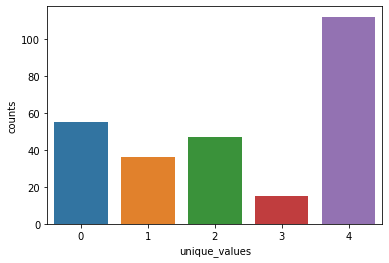

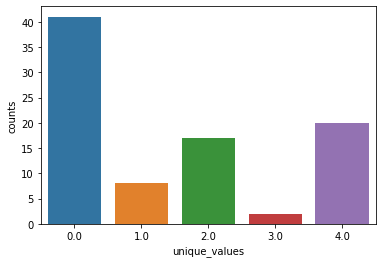

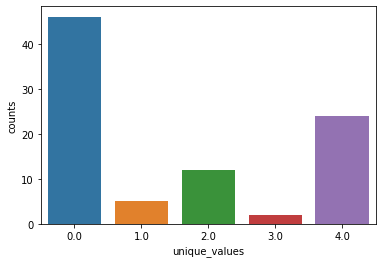

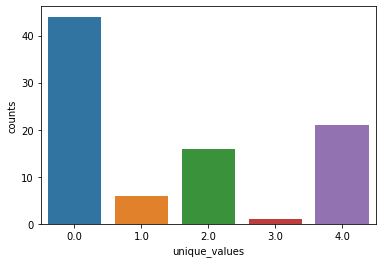

In [9]:
colname = ['label', 'iter0', 'iter1', 'iter2']
for i in colname:
    value_counts = results[i].value_counts(dropna=True, sort=True)
    df_val_counts = pd.DataFrame(value_counts)
    df_value_counts_reset = df_val_counts.reset_index()
    df_value_counts_reset.columns = ['unique_values', 'counts'] # change column names
    plt.figure()
    sns.barplot(x=df_value_counts_reset['unique_values'],y=df_value_counts_reset['counts'])

In [12]:
result = results.sort_values('label')
results[colname].to_csv('BMM_bootstrap.csv')

In [13]:
sw_results = pd.concat([results[colname], sw_full[['sorensen','alpha','simpson']]],axis=1)
sw_results.head()

,label,iter0,iter1,iter2,sorensen,alpha,simpson
sample_id,,,,,,,
SW_S19S.0003_U_1,0,4.0,NaN,NaN,0.000000,2335,0.999572
SW_S19S.0003_U_2,0,NaN,0.0,NaN,0.216343,2560,0.999609
SW_S19S.0003_U_3,4,NaN,NaN,0.0,0.202267,2782,0.999641
SW_S19S.0004_U_1,4,0.0,NaN,NaN,0.192323,2823,0.999646
SW_S19S.0004_U_2,4,NaN,0.0,NaN,0.210607,2869,0.999651


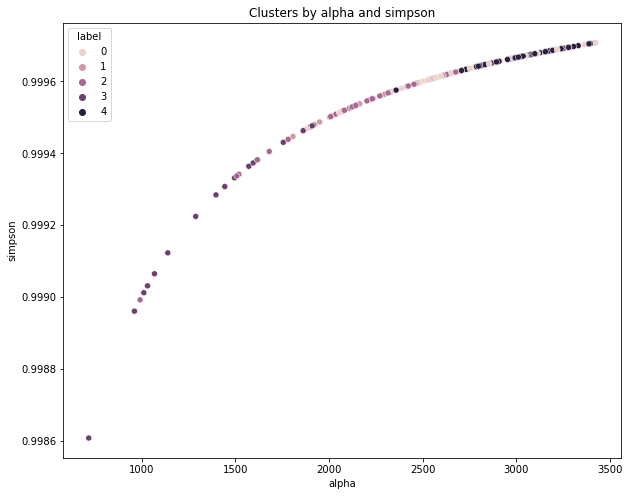

In [15]:
# Visualise
colname = ['alpha','simpson']
x_axis = sw_results[colname[0]]
y_axis = sw_results[colname[1]]
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = sw_results['label'])
plt.title('Clusters by ' + colname[0] + ' and ' + colname[1])
plt.show()

<AxesSubplot:xlabel='label', ylabel='simpson'>

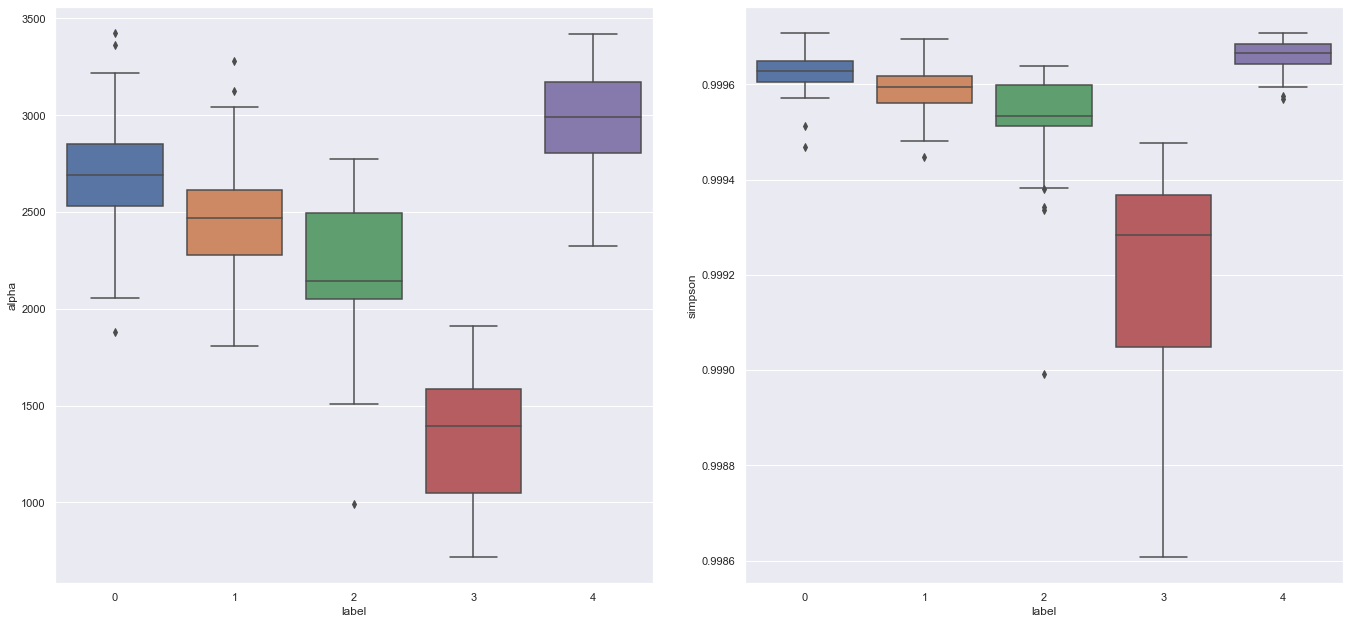

In [16]:
# Relationship between indices and cluster (numerical vs categorical)
sns.set(rc={'figure.figsize':(20,10)})
f,(ax1,ax2) = plt.subplots(1,2)

#plt.tight_layout()
plt.tight_layout(pad=5, w_pad=5, h_pad=1.0)

# boxplot to show distribution of numerical predictor such as balance or income w.r.t categories
sns.boxplot(x='label', y=colname[0], data=sw_results, orient='v',ax=ax1)
sns.boxplot(x='label', y=colname[1], data=sw_results, orient='v',ax=ax2)

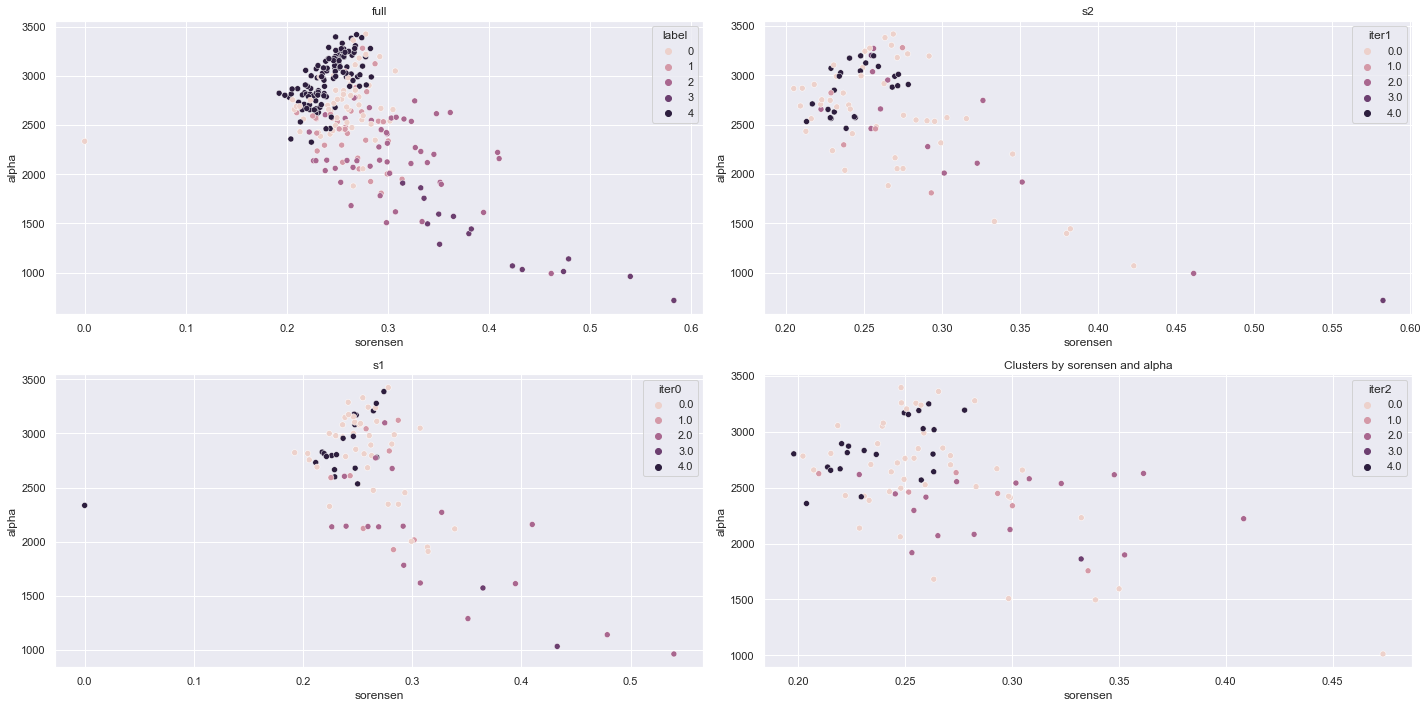

In [18]:
# Visualise
colname = ['sorensen','alpha']
x = sw_results[colname[0]]
y = sw_results[colname[1]]

fig, axs = plt.subplots(2, 2)


sns.scatterplot(x, y, hue = sw_results['label'], ax=axs[0, 0])
axs[0, 0].set_title("full")

sns.scatterplot(x, y, hue = sw_results['iter0'], ax=axs[1, 0])
axs[1, 0].set_title("s1")

sns.scatterplot(x, y, hue = sw_results['iter1'], ax=axs[0, 1])
axs[0, 1].set_title("s2")

sns.scatterplot(x, y, hue = sw_results['iter2'], ax=axs[1, 1])
axs[1, 1].set_title("s3")

fig.tight_layout()
plt.title('Clusters by ' + colname[0] + ' and ' + colname[1])
plt.show()

In [20]:
sw['cluster'] = sw_results['label']
sw = sw.drop(columns='sample')
temp = sw.groupby('cluster').any()
temp.sum(axis=1)

cluster
0    4556
1    4423
2    4409
3    2582
4    4563
dtype: int64

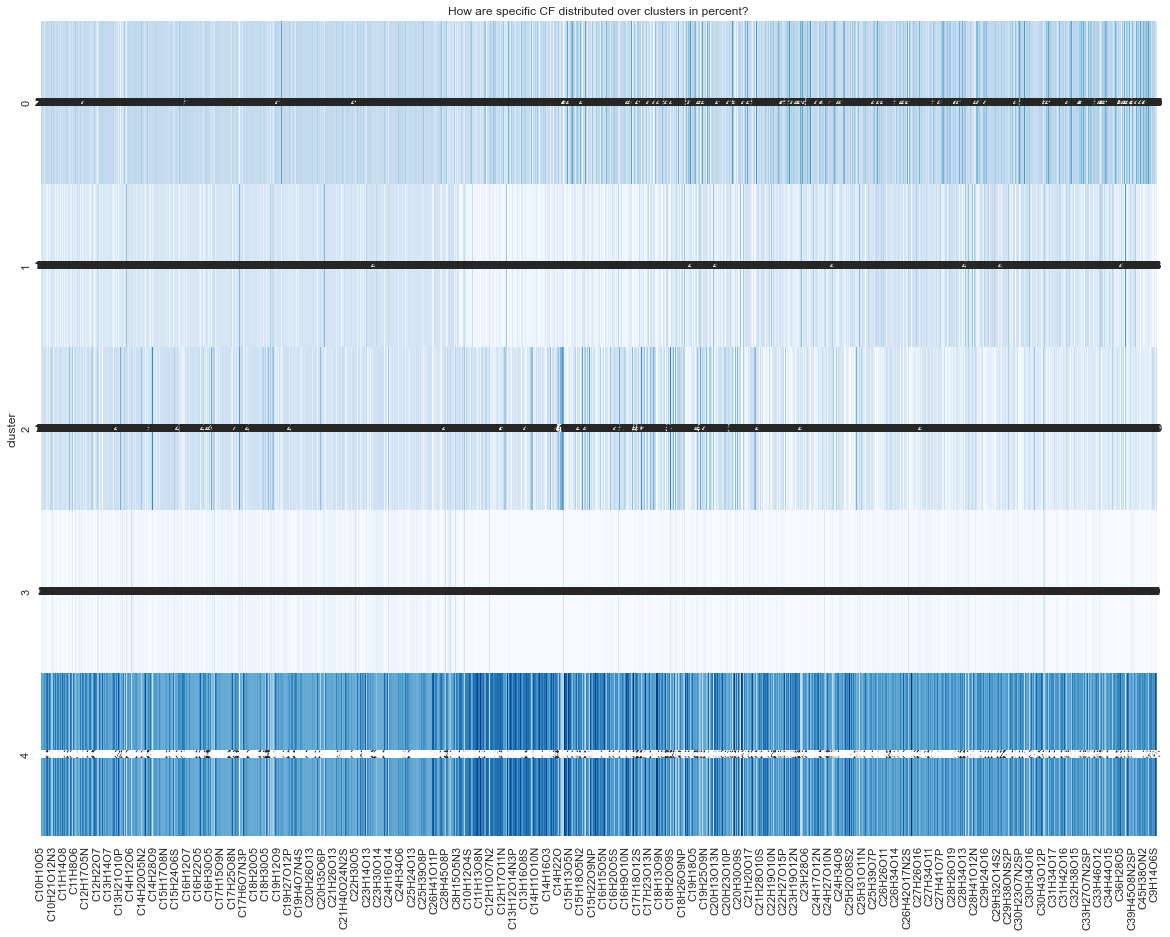

In [21]:
# Plot graph
grouped_targets = sw.groupby('cluster').sum() / sw.drop('cluster', axis=1).sum(axis=0) * 100
grouped_targets = grouped_targets.apply(np.round).astype(np.int32)
plt.figure(figsize=(20,15))
sns.heatmap(grouped_targets, cmap="Blues", annot=True, fmt="g", cbar=False);
plt.title("How are specific CF distributed over clusters in percent?");

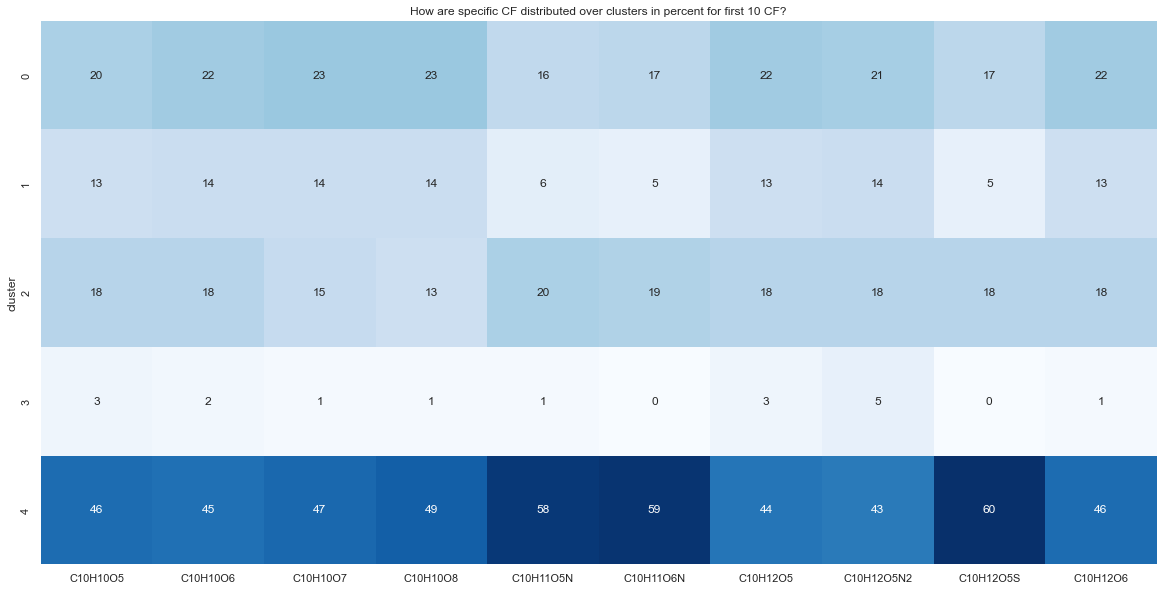

In [22]:
sns.heatmap(grouped_targets.iloc[:,:10], cmap="Blues", annot=True, fmt="g", cbar=False);
plt.title("How are specific CF distributed over clusters in percent for first 10 CF?");

In [23]:
grouped_targets.T.describe()

cluster,0,1,2,3,4
count,4563.000000,4563.000000,4563.000000,4563.000000,4563.000000
mean,22.453430,11.644094,13.866535,1.899847,50.156257
std,6.805542,6.401378,7.927910,2.468798,10.561189
min,0.000000,0.000000,0.000000,0.000000,7.000000
25%,20.000000,6.000000,9.000000,0.000000,44.000000
50%,22.000000,13.000000,14.000000,1.000000,49.000000
75%,25.000000,15.000000,18.000000,3.000000,57.000000
max,59.000000,48.000000,71.000000,20.000000,85.000000


(15, 5)
(10, 5)
(10, 5)
(17, 5)
(14, 5)
(66, 5)
Top unique CFs:(66, 5)


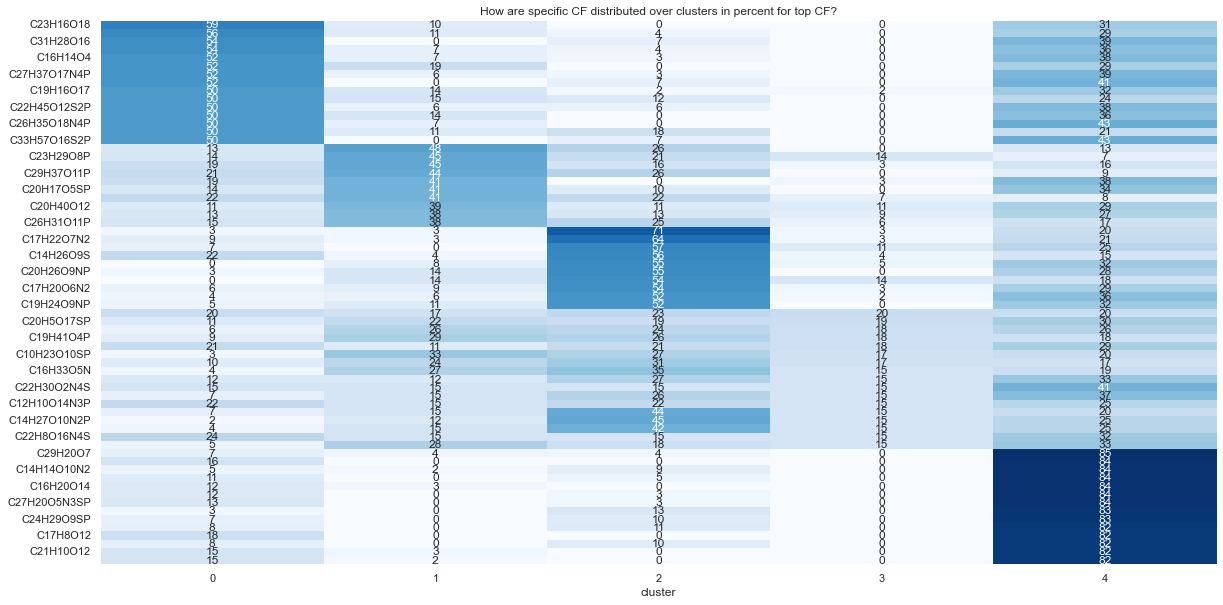

In [30]:
## Top 10 CFs in each cluster
colname = [0.0, 1.0, 2.0, 3.0, 4.0]
top_cf = pd.DataFrame()

for i in colname:
    temp = grouped_targets.T.nlargest(10, i, keep='all')
    print(temp.shape)
    top_cf = top_cf.append(temp)

print(top_cf.shape)
top_cf = top_cf[~top_cf.index.duplicated(keep='first')]
print('Top unique CFs:' + str(top_cf.shape))

sns.heatmap(top_cf, cmap="Blues", annot=True, fmt="g", cbar=False);
plt.title("How are specific CF distributed over clusters in percent for top CF?");

In [31]:
top_cf.to_csv('top_cf_by_cluster.csv')

Cluster 	Sample in this cluster	Types of CF present	Remarks

0	55	4556	
1	36	4423	
2	47	4409	
3	15	2582	
4	112	4563	


	265		
